# Two-Group, Two-Media Benchmark from [Criticality Verification Benchmark Suite](https://www.sciencedirect.com/science/article/pii/S0149197002000987/pdf?md5=299011580a5d17bc208703ef425a6ba6&pid=1-s2.0-S0149197002000987-main.pdf).
$$
\newcommand{\bo}{\boldsymbol{\hat{\Omega}}}
\newcommand{\x}{\boldsymbol{x}}
\newcommand{\o}{\Omega}
\newcommand{\p}{\partial}
\newcommand{\bm}{\boldsymbol}
\newcommand{\bx}{\boxed}
\newcommand{\f}{\frac}
\def\:#1\:{\begin{align}#1\end{align}}
\def\(#1\){\begin{\pmatrix}#1\end{pmatrix}}
\def\[#1\]{\begin{\bmatrix}#1\end{bmatrix}}
\def\s#1{\Sigma_{#1}}
\def\m#1{\mathcal{#1}}
$$
The case considered here is given by Tables 40, 41, and 42 in the [Criticality Verification Benchmark Suite](https://www.sciencedirect.com/science/article/pii/S0149197002000987/pdf?md5=299011580a5d17bc208703ef425a6ba6&pid=1-s2.0-S0149197002000987-main.pdf). I will only consider research reactor (b) which has the following cross sections.


| Material         | $\nu_1$ | $\s{f, 1}$ | $\s{\gamma, 1}$ | $\s{s, 1\rightarrow 1}$ | $\s{s, 2\rightarrow 1}$ | $\s{t, 1}$ | $\chi_1$ |
| --------------- | ------ | ---------- | -------------- | ----------------------- | ----------------------- | ---------- | -------- |
| $H_2O + ^{235}U$ | $2.50$  | $0.000836$ | $0.001104$      | $0.83892$               | $0.04635$               | $0.88721$  | $1.0$    |
| $H_2O$           | $0.0$   | $0.0$      | $0.00074$       | $0.83957$               | $0.04749$               | $0.88798$  | $0.0$    |

| Material         | $\nu_2$ | $\s{f, 2}$ | $\s{\gamma, 2}$ | $\s{s, 2\rightarrow 2}$ | $\s{s, 1\rightarrow 2}$ | $\s{t, 2}$ | $\chi_2$ |
| ---------------- | ------- | ---------- | --------------- | ----------------------- | ----------------------- | ---------- | -------- |
| $H_2O + ^{235}U$ | $2.50$  | $0.029564$ | $0.024069$      | $2.9183$                | $0.000767$              | $2.9727$   | $0.0$    |
| $H_2O$           | $0.0$   | $0.0$      | $0.018564$      | $2.9676$                | $0.000336$              | $2.9865$   | $0.0$    |

The critical dimensions for the two region slab problem are $6.696802~cm$ and $1.126151~cm$. Here we define the $H_2O + ^{235}U$ mixture first along the $+x$ direction followed by the $H_2O$ reflector. There is a reflective boundary condition at $x = 0$ and a vacuum boundary condition at $x = 6.696802 + 1.126151~cm$.

In [1]:
%load_ext autoreload
%autoreload 2

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = True

from tt_nte.benchmarks import research_reactor_multi_region
from tt_nte.methods import DiscreteOrdinates
from tt_nte import solvers

import supporting.plotting as tt_plt

To evaluate this problem using tt_nte, we created a 3-region problem with moderator regions of length $1.126151~cm$ on either side of a $13.393604~cm$ fuel region with vacuum boundary conditions on the outside. We evaluate the performance of the following solvers for $N\in \{2, 4, 8, 16, 32\}$ where $N$ is the total number of ordinates:

- Mat/GES: a generalized eigenvalue solver using matrix format (compressed sparse column (CSC) format),
- Mat/Power: power iteration in CSC format,
- TT-ALS: power iteration using ALS in TT format,
- TT-AMEn: power iteration using AMEn in TT format,
- QTT-MALS: power iteration using MALS in QTT format,
- QTT-AMEn: power iteration using AMEn in QTT format.

Each power iteration solver is allowed up to $2000$ iterations and the SVD threshold for QTT decomposition is $1\times 10^{-5}$.

-- Mat/GES
--   N = 2, k = 0.99059, exec_time = 0.011
--   N = 4, k = 0.99929, exec_time = 0.023
--   N = 8, k = 0.99985, exec_time = 0.164
--   N = 16, k = 0.99996, exec_time = 0.729
--   N = 32, k = 0.99999, exec_time = 3.306
-- Mat/Power
--   N = 2, k = 0.99051, exec_time = 1.334
--   N = 4, k = 0.99921, exec_time = 3.246
--   N = 8, k = 0.99977, exec_time = 9.519
--   N = 16, k = 0.99989, exec_time = 33.768
--   N = 32, k = 0.99991, exec_time = 125.278
-- TT-ALS
--   N = 2, k = 0.99052, exec_time = 244.603
--   N = 4, k = 0.99943, exec_time = 298.84
--   N = 8, k = 0.99991, exec_time = 449.817
--   N = 16, k = 1.00007, exec_time = 449.003
--   N = 32, k = 1.00016, exec_time = 413.833
-- TT-AMEn
--   N = 2, k = 0.99054, exec_time = 168.203
--   N = 4, k = 0.99922, exec_time = 531.41
--   N = 8, k = 0.99977, exec_time = 499.268
--   N = 16, k = 0.99989, exec_time = 479.162
--   N = 32, k = 0.99991, exec_time = 580.481
-- QTT-MALS
--   N = 2, k = 0.99053, exec_time = 27.259
--   N = 4

<Figure size 640x480 with 0 Axes>

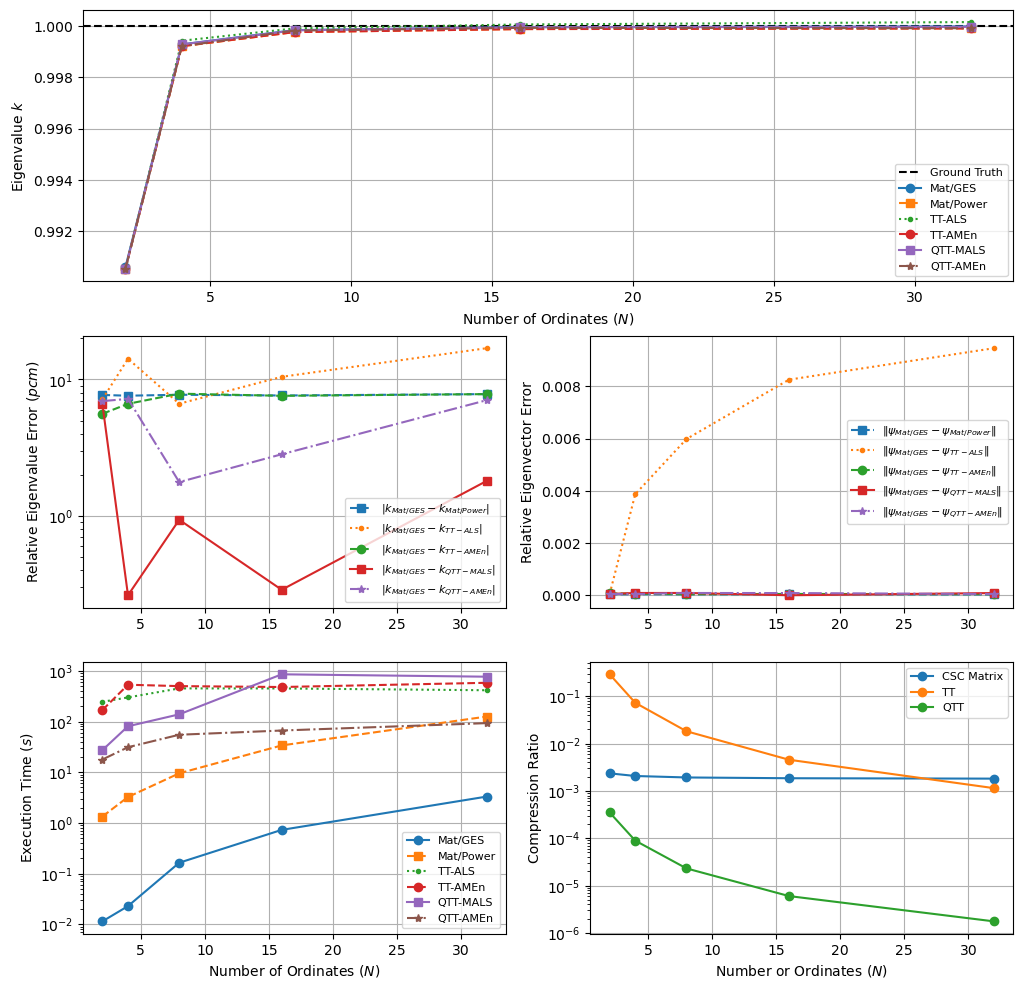

In [2]:
# Increase slab geometry fidelity
xs_server, geometry = research_reactor_multi_region([133, 760, 133], "vacuum")

# Initialize SN solver
SN = DiscreteOrdinates(
    xs_server=xs_server, 
    geometry=geometry, 
    num_ordinates=2,
    tt_fmt="tt",
)

# Define dictionary of solvers for plotting
tt_solvers = {
    "Mat/Power": (solvers.Matrix, {"tt_fmt": "tt"}, {}, {"max_iter": 2000}, "s--"),
    "TT-ALS": (solvers.ALS, {"tt_fmt": "tt"}, {}, {"max_iter": 2000}, ".:"),
    "TT-AMEn": (solvers.AMEn, {"tt_fmt": "tt"}, {}, {"max_iter": 2000}, "o--"),
    "QTT-MALS": (
        solvers.MALS, 
        {"tt_fmt": "qtt", "qtt_threshold": 1e-15}, 
        {}, 
        {"max_iter": 2000}, 
        "s-"
    ),
    "QTT-AMEn": (
        solvers.AMEn, 
        {"tt_fmt": "qtt", "qtt_threshold": 1e-15}, 
        {}, 
        {"max_iter": 2000},
        "*-."
    ),
}

num_ordinates = 2 ** np.arange(1, 6)

plt.clf()
fig = plt.figure(figsize=(12, 12))
tt_plt.plot_ordinate_perturbation(SN, num_ordinates, tt_solvers, fig=fig)
plt.savefig("figs/two_region_solvers.png", dpi=300)
plt.show()

Mat/GES is the most performant solver with all execution times less than 3 seconds and most below a second. This does not factor in the time to construct the full matrix operators. All solvers show the general trend of convergence to ground truth ($k = 1$) for increasing ordinates; however, TT-ALS overshoots the correct eigenvalue. This is likely due to the constraint set on the ranks of the solution. Higher ranks will allow TT-ALS to converge properly with a larger execution time. Of the TT/QTT solvers, AMEn is the most performant with high accuracy in the least amount of time. However, this may be due to its implementation. The AMEn matrix solver and Mat/GES call Fortran/C++ implementations that may be faster than the Python implementations of ALS, MALS, and GMRES.